# Data processing for Dehesa

# Setup
## Library import
We import all the required Python libraries

In [3]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
print(np.__version__)

1.21.4


# Data import
## Raster data
### Fire danger indicators
**Read data** 

In [5]:
data_dir = '../../datasets/raw/climate/dataset-sis-tourism-fire-danger-indicators/'
for ns, scenario in enumerate(['rcp45', 'rcp85']):
    for n, file in enumerate([i for i in os.listdir(data_dir) if scenario in i]):
        # convert to Dataset and concatenate by time
        if n == 0:
            ds_fire_sce = xr.open_dataset(data_dir+file, engine="netcdf4")
            # add scenario coordinate
            ds_fire_sce = ds_fire_sce.assign_coords({"scenario": scenario})
        else:
            ds = xr.open_dataset(data_dir+file, engine="netcdf4")
            # add scenario coordinate
            ds = ds.assign_coords({"scenario": scenario})
            ds_fire_sce = xr.concat([ds_fire_sce, ds], dim='time')
            
    if ns == 0:
        ds_fire = ds_fire_sce.copy()
    else:
        ds_fire = xr.concat([ds_fire, ds_fire_sce.copy()], dim='scenario')
        
ds_fire

<xarray.Dataset>
Dimensions:        (time: 93, rlon: 424, rlat: 412, scenario: 2, bnds: 2)
Coordinates:
  * time           (time) datetime64[ns] 2005-11-01 2006-11-01 ... 2097-11-01
  * rlon           (rlon) float64 -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
  * rlat           (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
    lon            (rlat, rlon) float64 -10.06 -9.964 -9.864 ... 64.76 64.96
    lat            (rlat, rlon) float64 21.99 22.03 22.07 ... 66.81 66.75 66.69
  * scenario       (scenario) <U5 'rcp45' 'rcp85'
Dimensions without coordinates: bnds
Data variables:
    rotated_pole   (scenario, time) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b''
    time_bnds      (scenario, time, bnds) datetime64[ns] 2005-11-01 ... 2098-...
    fwi-mean-jjas  (scenario, time, rlat, rlon) float64 59.63 61.19 ... 3.144
Attributes: (12/13)
    creation_date:  2019-06-19-T09:10:38Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-mean-jjas
    references:     van Wagner, C. E., (1987). Development and structure of a...
    ...             ...
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    comment:        None
    License:        License to Use Copernicus Products

**Clip area**

Bounding box spain:

In [6]:
x_min, y_min, x_max, y_max = (-25, -15, -10, -3)

ds_fire = ds_fire.sel(rlon=slice(x_min, x_max), rlat=slice(y_min, y_max)).copy()

**Resample time**

In [7]:
ds_fire = ds_fire.assign_coords({"time": pd.DatetimeIndex(ds_fire.time.values).year+1})

da_fire = ds_fire['fwi-mean-jjas'].copy()
attrs = ds_fire.attrs
for n, years in enumerate([[2006,2020], [2021, 2040], [2041, 2060], [2061, 2080], [2081, 2098]]):
    da_fire_sce = da_fire.sel(time=slice(years[0],years[1])).mean('time').assign_coords({"time": f'{years[0]}-{years[1]}'})
    
    if n == 0:
        da = da_fire_sce.copy()
    else:
        da = xr.concat([da, da_fire_sce.copy()], dim='time')
        
ds_fire = da.to_dataset().assign_attrs(attrs)
ds_fire

<xarray.Dataset>
Dimensions:        (rlon: 137, rlat: 109, scenario: 2, time: 5)
Coordinates:
  * rlon           (rlon) float64 -24.96 -24.86 -24.75 ... -10.23 -10.11 -10.0
  * rlat           (rlat) float64 -14.9 -14.79 -14.69 ... -3.245 -3.135 -3.025
    lon            (rlat, rlon) float64 -10.43 -10.31 -10.2 ... 3.023 3.18 3.338
    lat            (rlat, rlon) float64 31.04 31.08 31.12 ... 46.69 46.71 46.73
  * scenario       (scenario) <U5 'rcp45' 'rcp85'
  * time           (time) <U9 '2006-2020' '2021-2040' ... '2081-2098'
Data variables:
    fwi-mean-jjas  (time, scenario, rlat, rlon) float64 nan nan ... 11.44 10.75
Attributes: (12/13)
    creation_date:  2019-06-19-T09:10:38Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-mean-jjas
    references:     van Wagner, C. E., (1987). Development and structure of a...
    ...             ...
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    comment:        None
    License:        License to Use Copernicus Products

**Display data**

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


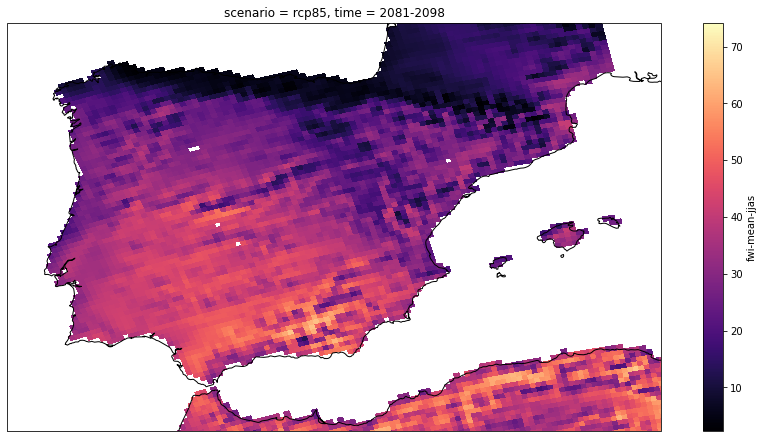

In [8]:
fig, ax = plt.subplots(figsize=(15,7.5))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

ds_fire['fwi-mean-jjas'].isel(time=-1).sel(scenario='rcp85').plot.pcolormesh(ax=ax, cmap='magma', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax.coastlines()

lon_min, lat_min, lon_max, lat_max = (-9.39288367353, 35.946850084, 4.32841, 43.7483377142)
ax.set_ylim([lat_min-1,lat_max+1]);
ax.set_xlim([lon_min-1,lon_max+1]);

## Vector data 
### Spain
**Read data**

In [9]:
spain = gpd.read_file('../../datasets/processed/spain.geojson', driver='GeoJSON')

### Provincias
**Read data**

In [20]:
provincias = gpd.read_file(f'../../datasets/raw/georegions/Provincias/Provincias.shp')
provincias.sort_values(['CO_CCAA', 'CO_PROVINC'], inplace = True)

### Mapa de cultivos
**Read data**

In [10]:
gdf_corine = gpd.read_file('../../datasets/raw/crops/CLC2018_GDB/CLC2018_ES.gdb', driver="FileGDB", layer='CLC18_ES')
# Re-Project
gdf_corine = gdf_corine.to_crs("EPSG:4326")
gdf_corine = gdf_corine.set_crs("EPSG:4326")

In [13]:
gdf_dehesa = gdf_corine[gdf_corine['CODE_18'].isin(['244'])].copy()

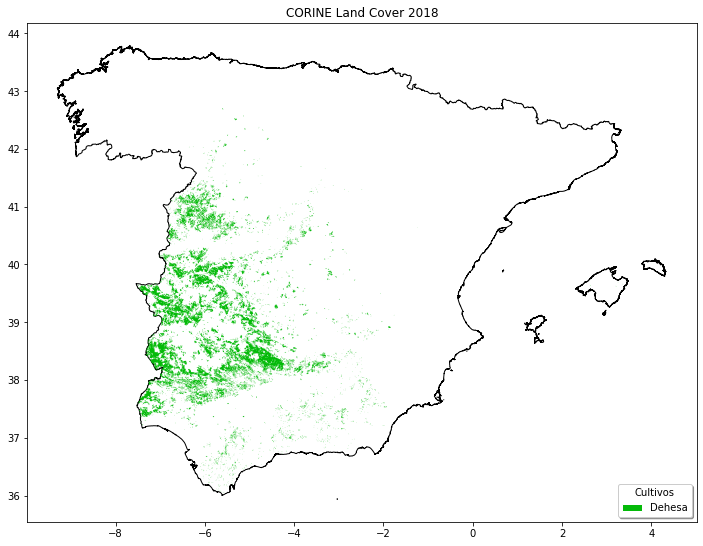

In [14]:
fig, ax = plt.subplots(figsize=(12,12))

spain.plot(ax=ax, color='w', edgecolor='k')
gdf_dehesa.plot(ax=ax, color='#04BA09', label= 'Dehesa', legend=True)

ax.set_title('CORINE Land Cover 2018')

# Adding custom legend

pmark = mpatches.Patch(facecolor='#04BA09',
                       edgecolor='white',
                       linestyle='-',
                       alpha=1,
                       label='Dehesa')


handles, _ = ax.get_legend_handles_labels()
ax.legend(
    handles=[
        *handles,
        pmark,
    ],
    title="Cultivos",
    loc='lower right',
    ncol=1,
    shadow=True)

# show figure
plt.rcParams['legend.title_fontsize'] = 10
plt.show()

#### **Extensión**
**España**

In [17]:
print(f"Extensión total españa {gdf_dehesa['AREA_HA'].sum()}")

Extensión total españa 2376434.3774871975


**Extremadura**

In [32]:
provincias[provincias['DS_CCAA'] == 'Extremadura'].dissolve(by='DS_CCAA').geometry
gdf_dehesa_ext = gdf_dehesa[gdf_dehesa.intersects(provincias[provincias['DS_CCAA'] == 'Extremadura'].dissolve(by='DS_CCAA').geometry.iloc[0])]
gdf_dehesa_ext.head()

,CODE_18,AREA_HA,Shape_Length,Shape_Area,ID,geometry
105403,244,679.304011,37806.064357,6.793040e+06,105409,"MULTIPOLYGON (((-5.99563 38.00014, -5.99411 37..."
105418,244,25.357353,2596.558063,2.535735e+05,105424,"MULTIPOLYGON (((-6.18725 38.00227, -6.18710 38..."
105436,244,133.608691,13444.824503,1.336087e+06,105442,"MULTIPOLYGON (((-5.96094 38.01744, -5.96117 38..."
105443,244,40.817596,3255.161175,4.081760e+05,105449,"MULTIPOLYGON (((-6.19392 38.01425, -6.19390 38..."
105444,244,30.303912,2982.149390,3.030391e+05,105450,"MULTIPOLYGON (((-5.97108 38.02384, -5.97098 38..."


<AxesSubplot:>

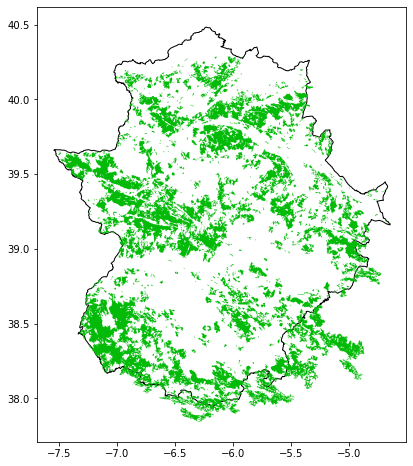

In [35]:
fig, ax = plt.subplots(figsize=(8,8))

provincias[provincias['DS_CCAA'] == 'Extremadura'].dissolve(by='DS_CCAA').plot(ax=ax, color='w', edgecolor='k')
gdf_dehesa_ext.plot(ax=ax, color='#04BA09', label= 'Dehesa', legend=True)


In [36]:
print(f"Extensión total Extremadura {gdf_dehesa_ext['AREA_HA'].sum()}")

Extensión total Extremadura 1289815.3266498437


# Zonal statistics
**Get value over time**

In [29]:
gdf_dehesa.reset_index(drop=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [36]:
def number_of_digits(x):
    """Get number of digits to the left/right of a decimal point"""
    # Number of digits to the left of the decimal point
    dig_left = int(np.log10(x))+1
    # Number of digits to the right of the decimal point
    if '.' in str(x):
        decList = [int(y) for y in list(str(x).split('.')[1])]
        dig_right = next((i for i, x in enumerate(decList) if x), None) + 1
    else:
        dig_right = 0
        
    return dig_left, dig_right

In [38]:
def find_nearest(array, value):
    """Find nearest value in numpy array"""
    array = np.asarray(array)
    
    # Get the mean step values
    step = np.abs(np.diff(array)).max()*1.5
    
    # Find the nearest values
    diff = np.abs(array - value)
    idx = np.argwhere((diff >= np.amin(diff) - step) & (diff <= np.amin(diff) + step))

    return idx

In [31]:
def get_nearest_xy_from_latlon(ds, lat, lon, lon_name='lon', lat_name='lat'):
    """Return the x/y values for a given longitude/latitude values"""
    # Read all lon/lat values
    lons = ds[lon_name].data
    lats = ds[lat_name].data
    
    # Get mean lon/lat step size 
    mean_lat_size = np.abs(np.diff(lats)).mean()
    #print(mean_y_size)
    mean_lon_size = np.abs(np.diff(lons)).mean()
    
    # Round lon/lat values to the first decimal place
    dig_left, dig_right = number_of_digits(mean_lat_size) 
    if dig_right == 0: 
        lat = round(lat)
    else:
        lat = round(lat, dig_right)
        
    dig_left, dig_right = number_of_digits(mean_lon_size) 
    if dig_right == 0: 
        lon = round(lon)
    else:
        lon = round(lon, dig_right)
    
    # Find the positions of the nearest longitude/latitude values
    idx_lon = find_nearest(lons, lon)
    idx_lat = find_nearest(lats, lat)
    
    # Check the identical rows in both arrays
    res = (idx_lon[:, None] == idx_lat).all(-1).any(-1)
    yx_positions = idx_lon[res]
    
    
    if yx_positions.shape[0] == 0:
        raise Exception("Sorry, lat/lon values outside data domain")   
    if yx_positions.shape[0] > 1:
        # If more than one identical rows take the row nearest to the mean value
        yx_positions = np.mean(yx_positions,axis=0).astype(int).reshape(1,2)

    # Get the x/y values
    x_position = yx_positions[0][1]
    y_position = yx_positions[0][0]
    
    x = ds.rlon.data[yx_positions[0][1]]
    y = ds.rlat.data[yx_positions[0][0]]

    return x_position, y_position, x, y

In [30]:
def get_centroid_values(gdf, ds, da, lon_name='lon', lat_name='lat'):  
    #Add geometries smaller than mean cell size into the mask
    gdf['centroid'] = gdf['geometry'].apply(lambda x: x.centroid)
    
    values = []
    for id_int in tqdm(gdf.index):
        lon = gdf['centroid'].loc[id_int].x
        lat = gdf['centroid'].loc[id_int].y
        
        # Get x/y positions for the corresponding longitude/latitude values
        x_pos, y_pos, x, y = get_nearest_xy_from_latlon(ds, lat, lon, lon_name=lon_name, lat_name=lat_name)
        
        # Replace cell value with new int
        values.append(da.data[:, y_pos, x_pos])
            
    return values

In [39]:
gdf = gdf_dehesa.copy()
#Reset index
gdf = gdf.reset_index(drop=True)

ds = ds_fire.copy()
indicator = 'fwi-mean-jjas'
for scenario in ds.scenario.data:
    print(scenario)
    centroid_values = get_centroid_values(gdf, ds, ds[indicator].sel(scenario=scenario), lon_name='lon', lat_name='lat')

    df = pd.DataFrame({'index': list(gdf.index),\
                      f'{indicator} ({scenario})': centroid_values,
                      f'{indicator} ({scenario}) (time)': [list(ds.coords['time'].values)]*len(centroid_values)})

    gdf = pd.merge(gdf.reset_index(), df, how = 'left', on = 'index').drop(columns='index')

rcp45


100%|██████████| 4895/4895 [00:02<00:00, 1825.41it/s]


rcp85


100%|██████████| 4895/4895 [00:02<00:00, 1805.33it/s]


In [42]:
gdf

,CODE_18,AREA_HA,Shape_Length,Shape_Area,ID,geometry,fwi-mean-jjas (rcp45),fwi-mean-jjas (rcp45) (time),fwi-mean-jjas (rcp85),fwi-mean-jjas (rcp85) (time)
0,244,53.252875,6306.123785,5.325287e+05,103701,"MULTIPOLYGON (((-5.57217 36.05634, -5.57214 36...","[nan, nan, nan, nan, nan]","[2006-2020, 2021-2040, 2041-2060, 2061-2080, 2...","[nan, nan, nan, nan, nan]","[2006-2020, 2021-2040, 2041-2060, 2061-2080, 2..."
1,244,27.472134,4042.806142,2.747213e+05,103702,"MULTIPOLYGON (((-5.56852 36.06253, -5.56817 36...","[nan, nan, nan, nan, nan]","[2006-2020, 2021-2040, 2041-2060, 2061-2080, 2...","[nan, nan, nan, nan, nan]","[2006-2020, 2021-2040, 2041-2060, 2061-2080, 2..."
2,244,88.985476,5903.637891,8.898548e+05,103703,"MULTIPOLYGON (((-5.64160 36.08095, -5.64124 36...","[nan, nan, nan, nan, nan]","[2006-2020, 2021-2040, 2041-2060, 2061-2080, 2...","[nan, nan, nan, nan, nan]","[2006-2020, 2021-2040, 2041-2060, 2061-2080, 2..."
3,244,26.274312,7111.642675,2.627431e+05,103704,"MULTIPOLYGON (((-5.67913 36.09335, -5.67909 36...","[nan, nan, nan, nan, nan]","[2006-2020, 2021-2040, 2041-2060, 2061-2080, 2...","[nan, nan, nan, nan, nan]","[2006-2020, 2021-2040, 2041-2060, 2061-2080, 2..."
4,244,36.449251,5886.625731,3.644925e+05,103705,"MULTIPOLYGON (((-5.70005 36.09426, -5.69969 36...","[nan, nan, nan, nan, nan]","[2006-2020, 2021-2040, 2041-2060, 2061-2080, 2...","[nan, nan, nan, nan, nan]","[2006-2020, 2021-2040, 2041-2060, 2061-2080, 2..."
...,...,...,...,...,...,...,...,...,...,...
4890,244,748.385665,28183.648818,7.483857e+06,108593,"MULTIPOLYGON (((-5.29147 42.52059, -5.29159 42...","[15.352209864592506, 17.08286825180053, 19.093...","[2006-2020, 2021-2040, 2041-2060, 2061-2080, 2...","[15.903411022281206, 17.298769489924116, 19.90...","[2006-2020, 2021-2040, 2041-2060, 2061-2080, 2..."
4891,244,146.639116,5699.023452,1.466391e+06,108594,"MULTIPOLYGON (((-5.33278 42.53061, -5.33293 42...","[15.352209864592506, 17.08286825180053, 19.093...","[2006-2020, 2021-2040, 2041-2060, 2061-2080, 2...","[15.903411022281206, 17.298769489924116, 19.90...","[2006-2020, 2021-2040, 2041-2060, 2061-2080, 2..."
4892,244,113.819391,5192.002332,1.138194e+06,108595,"MULTIPOLYGON (((-5.12737 42.57426, -5.12730 42...","[12.114159497019156, 13.675992786884308, 15.54...","[2006-2020, 2021-2040, 2041-2060, 2061-2080, 2...","[12.137392397052457, 13.56021478176117, 16.054...","[2006-2020, 2021-2040, 2041-2060, 2061-2080, 2..."
4893,244,35.628131,5064.197053,3.562813e+05,108596,"MULTIPOLYGON (((-5.58897 42.69291, -5.58868 42...","[12.498196481599832, 14.019028668403626, 15.95...","[2006-2020, 2021-2040, 2041-2060, 2061-2080, 2...","[12.72165948319124, 14.205799408753714, 16.840...","[2006-2020, 2021-2040, 2041-2060, 2061-2080, 2..."


**Reorganice indicator table**

In [49]:
gdf_ids = ['ID']
df = pd.DataFrame(columns=gdf_ids + ['dataset', 'indicator', 'scenario', 'value', 'year'])
for scenario in ds.scenario.data:
    print(scenario)
    df_tmp = gdf[gdf_ids + [f'{indicator} ({scenario})', f'{indicator} ({scenario}) (time)']].copy()
    df_tmp.rename(columns={f'{indicator} ({scenario})': 'value', f'{indicator} ({scenario}) (time)': 'year'}, inplace=True)
    df_tmp['dataset'] = "Fire danger indicator"
    df_tmp['indicator'] = indicator
    df_tmp['scenario'] = scenario

    # Convert list-like columns (values and years) elements to separate rows
    df_tmp_melt = df_tmp.drop(["year"], axis = 1).copy()

    df_tmp_melt = df_tmp_melt['value'].apply(pd.Series)\
    .merge(df_tmp_melt, right_index = True, left_index = True)\
    .drop(["value"], axis = 1)\
    .reset_index()\
    .melt(id_vars = gdf_ids + ['index', 'dataset', 'indicator', 'scenario'], value_name = "value")\
    .sort_values(['index', 'variable'])\
    .drop(["index", 'variable'], axis = 1)

    df_tmp_melt['year'] = df_tmp['year'].iloc[0]*len(df_tmp)

    df = pd.concat([df, df_tmp_melt])

    df.reset_index(drop=True, inplace=True)
                
# Add units
df['unit'] = ''

rcp45
rcp85


In [50]:
df

,ID,dataset,indicator,scenario,value,year,unit
0,103701,Fire danger indicator,fwi-mean-jjas,rcp45,NaN,2006-2020,
1,103701,Fire danger indicator,fwi-mean-jjas,rcp45,NaN,2021-2040,
2,103701,Fire danger indicator,fwi-mean-jjas,rcp45,NaN,2041-2060,
3,103701,Fire danger indicator,fwi-mean-jjas,rcp45,NaN,2061-2080,
4,103701,Fire danger indicator,fwi-mean-jjas,rcp45,NaN,2081-2098,
...,...,...,...,...,...,...,...
48945,108597,Fire danger indicator,fwi-mean-jjas,rcp85,12.721659,2006-2020,
48946,108597,Fire danger indicator,fwi-mean-jjas,rcp85,14.205799,2021-2040,
48947,108597,Fire danger indicator,fwi-mean-jjas,rcp85,16.840866,2041-2060,
48948,108597,Fire danger indicator,fwi-mean-jjas,rcp85,19.344280,2061-2080,


**Save tables**

In [51]:
df.to_csv(f'../../datasets/processed/fire_danger_dehesa.csv', index = False)

**Display output/input figures**

In [62]:
scenario = 'rcp45'
year = '2061-2080'

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


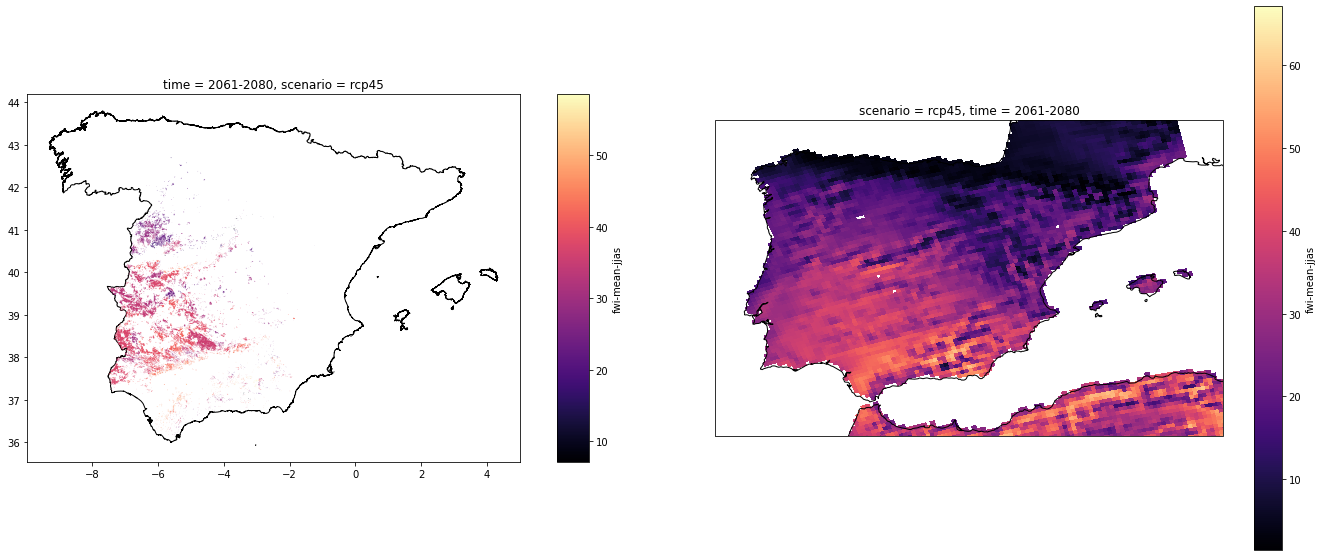

In [63]:
df_tmp = df[(df['scenario'] == scenario) & (df['year'] == year)].copy()

df_tmp = pd.merge(gdf_dehesa,  df_tmp, on='ID', how='left')

fig = plt.figure(figsize=(25,10))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=-0.5) 
spain.plot(ax=ax1, color='w', edgecolor='k')
df_tmp.plot(ax=ax1, column='value', cmap='magma', legend=True, cax=cax, legend_kwds={'label': indicator})
ax1.set_title(f'time = {year}, scenario = {scenario}')


ax2.set_global()
ds_fire.sel(scenario=scenario).sel(time=year)[indicator].plot.pcolormesh(ax=ax2, cmap='magma', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax2.coastlines()
ax2.set_ylim([lat_min-1,lat_max+1]);
ax2.set_xlim([lon_min-1,lon_max+1]);